# Analiza różnic w rankigach

Analiza różnic pomiędzy:
- dokładną metodą - exact_ranking
- metodą przybliżania dla 1000 iteracji

In [1]:
import os
while "notebooks" in os.getcwd():
    os.chdir("../")


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Wczytywanie rankingów i zbioru danych

In [3]:
result_path = Path("results")
exact_ranking_data_path = result_path / "wine_exact_ranking.npy"
approx_ranking_data_path = result_path / "wine_approx_ranking_4000_iter.npy"
shap_ranking_data = result_path / "wine_shap_ranking.npy"
data_path = Path("data")
wine_test_data_path = data_path / "wine_quality/test_winequality_red_scaled.csv"

In [71]:
pgi_wine_exact_path = result_path / "pgi_wine_exact_ranking.npy"
pgi_wine_shap_path = result_path / "pgi_wine_shap_ranking.npy"
pgi_wine_approx_path = result_path / "pgi_wine_approx_ranking_4000_iter.npy"

In [4]:
wine_data = pd.read_csv(wine_test_data_path)
wine_data

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,-0.241094,-1.887226,0.765247,-0.666062,-0.647527,0.203223,-0.500769,-1.455778,-0.136798,0.187963,0.729364,6
1,-1.045437,-1.049255,-0.005010,0.185312,-0.434990,-0.753085,-0.075043,-1.540580,-0.655141,-0.579207,1.480302,6
2,0.103624,-1.160984,0.765247,-0.169427,-0.264960,-0.370562,-0.835267,-1.275573,-1.108690,0.305990,1.292568,7
3,-0.700719,-0.546472,0.765247,2.100902,-0.349975,1.159531,2.479310,0.293268,0.705508,0.305990,0.072294,5
4,2.229387,-0.434742,1.124700,-0.807957,-0.264960,-1.231239,-1.230584,0.081262,-1.173483,-0.166115,-0.021574,5
...,...,...,...,...,...,...,...,...,...,...,...,...
315,-0.470907,0.291499,1.484154,0.398155,1.392830,-1.039977,-0.987312,-1.052967,-0.655141,2.194408,1.104833,6
316,-0.068735,-0.993390,0.303093,-0.098479,-0.243707,-0.466193,0.016184,-0.401050,-0.266384,0.896120,0.541630,6
317,0.390889,-0.323013,0.200392,0.114364,-0.073677,0.777007,2.388083,0.876283,-0.007213,-0.284141,-0.960246,5
318,0.046171,1.045674,-0.364463,-0.098479,-0.243707,-0.561823,-0.257497,0.319768,-0.007213,-0.107102,-0.960246,5


In [5]:
exact_ranking = np.load(exact_ranking_data_path)
exact_ranking.shape

(320, 11)

In [6]:
approx_ranking_4000 = np.load(approx_ranking_data_path)

In [7]:
shap_ranking = np.load(shap_ranking_data)
shap_ranking.shape

(320, 11)

# Analiza różnic w rankingach exact vs approx

In [8]:
features_map = {}
for indx, name in enumerate(list(wine_data.columns.values)):
    features_map[name] = indx

In [9]:
def map_features(li: list):
    mapped_li = [features_map[i] for i in li]
    return mapped_li

In [10]:

def distance_between_lists(a: list, b: list):
    a = map_features(a)
    b = map_features(b)
    a_s = set(a)
    b_s = set(b)
    [a.append(i) for i in list(b_s-a_s)]
    [b.append(i) for i in list(a_s-b_s)]
    max_val = max(max(a), max(b))
    all_numbers_set = set(range(max_val))
    a_s = set(a)
    b_s = set(b)
    [a.append(i) for i in list(all_numbers_set - a_s)]
    [b.append(i) for i in list(all_numbers_set - b_s)]
    return cayley_distance(a, b)

def cayley_distance(x: list, y: list):
    A = range(len(x))
    inv_y = tuple(y.index(a) for a in A)
    comp = tuple(x[inv_y[a]] for a in A)
    cycles = 0
    rem = set(A)
    while rem:
        a = rem.pop()
        cycles += 1
        while comp[a] in rem:
            a = comp[a]
            rem.remove(a)
    return len(A) - cycles


## Caylel distance

### All features

Porównanie obu rankingów za pomocą dystansu cayleya używając wszystkich cech

In [11]:
differences_all = []
for i, j in zip(exact_ranking, approx_ranking_4000):
    diff = distance_between_lists(i, j)
    differences_all.append(diff)

In [12]:
np.mean(differences_all)

4.559375

In [13]:
np.max(differences_all)

10

In [14]:
np.min(differences_all)

0

<Axes: >

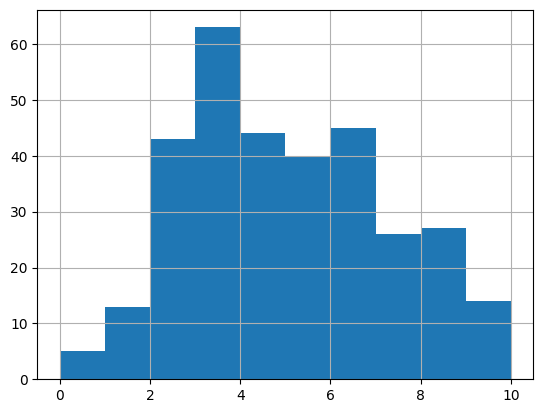

In [15]:
diff_ser = pd.Series(differences_all)
diff_ser.hist(bins=10)

In [16]:
indexes = [i for i, x in enumerate(differences_all) if x == 10]
indexes


[151]

In [17]:
print(exact_ranking[indexes[0]])
print(approx_ranking_4000[indexes[0]])

['residual_sugar' 'chlorides' 'pH' 'total_sulfur_dioxide'
 'free_sulfur_dioxide' 'fixed_acidity' 'volatile_acidity' 'citric_acid'
 'alcohol' 'sulphates' 'density']
['alcohol' 'residual_sugar' 'volatile_acidity' 'sulphates' 'citric_acid'
 'free_sulfur_dioxide' 'total_sulfur_dioxide' 'density' 'pH'
 'fixed_acidity' 'chlorides']


### Top 5 features

In [18]:
differences_5 = []
for i, j in zip(exact_ranking, approx_ranking_4000):
    i = i[0:5]
    j = j[0:5]
    diff = distance_between_lists(i, j)
    differences_5.append(diff)

In [19]:
np.mean(differences_5)

2.03125

In [20]:
np.max(differences_5)

8

In [21]:
np.min(differences_5)

0

<Axes: >

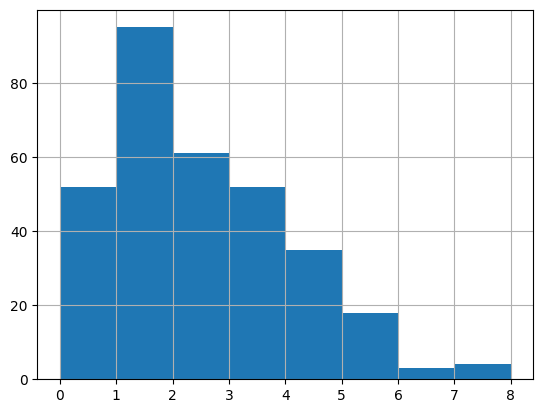

In [22]:
diff_ser = pd.Series(differences_5)
diff_ser.hist(bins=8)

In [23]:
indexes = [i for i, x in enumerate(differences_5) if x == 8]
indexes


[319]

In [24]:
print(exact_ranking[indexes[0]])
print(approx_ranking_4000[indexes[0]])

['pH' 'residual_sugar' 'sulphates' 'alcohol' 'density' 'volatile_acidity'
 'fixed_acidity' 'citric_acid' 'chlorides' 'total_sulfur_dioxide'
 'free_sulfur_dioxide']
['chlorides' 'volatile_acidity' 'total_sulfur_dioxide' 'sulphates'
 'free_sulfur_dioxide' 'fixed_acidity' 'density' 'citric_acid'
 'residual_sugar' 'pH' 'alcohol']


### Top 3 features

In [25]:
differences_3 = []
for i, j in zip(exact_ranking, approx_ranking_4000):
    i = i[0:3]
    j = j[0:3]
    diff = distance_between_lists(i, j)
    differences_3.append(diff)

In [26]:
np.mean(differences_3)

0.90625

In [27]:
np.max(differences_3)

5

In [28]:
np.min(differences_3)

0

<Axes: >

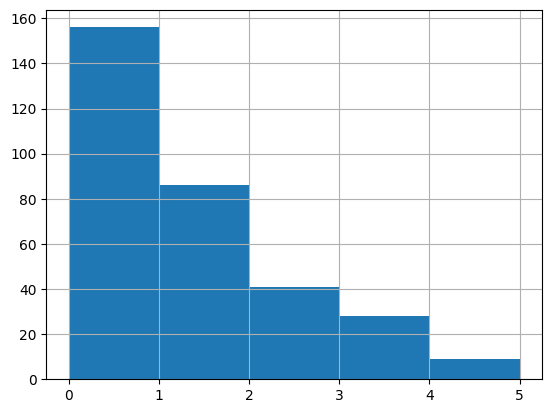

In [29]:
diff_ser = pd.Series(differences_3)
diff_ser.hist(bins=5)

In [30]:
indexes = [i for i, x in enumerate(differences_3) if x == 3]
indexes


[33,
 40,
 46,
 67,
 69,
 101,
 105,
 106,
 108,
 111,
 127,
 143,
 151,
 174,
 178,
 183,
 184,
 200,
 217,
 218,
 228,
 240,
 246,
 252,
 264,
 271,
 284,
 288]

In [31]:
print(exact_ranking[indexes[0]])
print(approx_ranking_4000[indexes[0]])

['pH' 'chlorides' 'total_sulfur_dioxide' 'volatile_acidity'
 'residual_sugar' 'citric_acid' 'density' 'fixed_acidity'
 'free_sulfur_dioxide' 'sulphates' 'alcohol']
['sulphates' 'pH' 'alcohol' 'volatile_acidity' 'total_sulfur_dioxide'
 'chlorides' 'residual_sugar' 'citric_acid' 'density' 'fixed_acidity'
 'free_sulfur_dioxide']


## Diffrence between sets

Porównaie używając tylko różicy w zbiorach top k cech - bez brania pod uwagę kolejności

In [32]:
def set_difference(a: list, b: list):
    a_s = set(a)
    b_s = set(b)
    diff = a_s.difference(b_s) 
    return len(diff)

### Top 5 features

In [33]:
set_differences_5 = []
for i, j in zip(exact_ranking, approx_ranking_4000):
    i = i[0:5]
    j = j[0:5]
    diff = set_difference(i, j)
    set_differences_5.append(diff)

In [34]:
np.mean(set_differences_5)

0.853125

In [35]:
np.max(set_differences_5)

4

In [36]:
np.min(set_differences_5)

0

<Axes: >

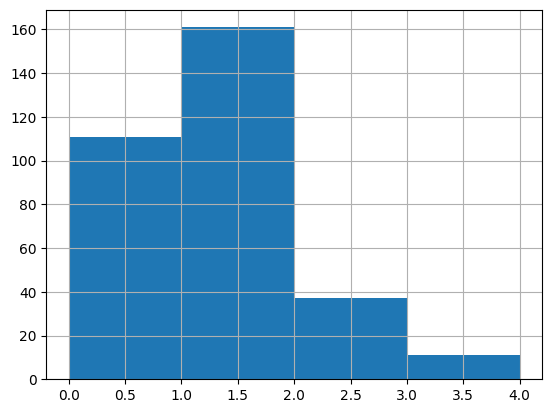

In [38]:
diff_ser = pd.Series(set_differences_5)
diff_ser.hist(bins=4)

In [39]:
indexes = [i for i, x in enumerate(set_differences_5) if x == 4]
indexes


[151, 183, 233, 295, 319]

In [40]:
print(exact_ranking[indexes[0]])
print(approx_ranking_4000[indexes[0]])

['residual_sugar' 'chlorides' 'pH' 'total_sulfur_dioxide'
 'free_sulfur_dioxide' 'fixed_acidity' 'volatile_acidity' 'citric_acid'
 'alcohol' 'sulphates' 'density']
['alcohol' 'residual_sugar' 'volatile_acidity' 'sulphates' 'citric_acid'
 'free_sulfur_dioxide' 'total_sulfur_dioxide' 'density' 'pH'
 'fixed_acidity' 'chlorides']


### Top 3 features

In [41]:
set_differences_3 = []
for i, j in zip(exact_ranking, approx_ranking_4000):
    i = i[0:3]
    j = j[0:3]
    diff = set_difference(i, j)
    set_differences_3.append(diff)

In [42]:
np.mean(set_differences_3)

0.5125

In [43]:
np.max(set_differences_3)

3

In [44]:
np.min(set_differences_3)

0

<Axes: >

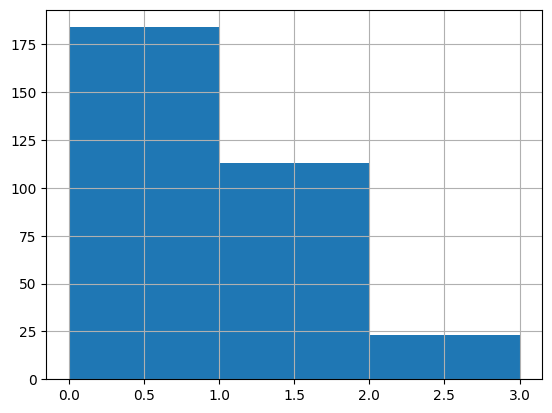

In [45]:
diff_ser = pd.Series(set_differences_3)
diff_ser.hist(bins=3)

In [46]:
indexes = [i for i, x in enumerate(set_differences_3) if x == 3]
indexes


[178, 183, 233, 293, 319]

In [47]:
print(exact_ranking[indexes[0]])
print(approx_ranking_4000[indexes[0]])

['residual_sugar' 'pH' 'density' 'chlorides' 'free_sulfur_dioxide'
 'total_sulfur_dioxide' 'fixed_acidity' 'sulphates' 'alcohol'
 'volatile_acidity' 'citric_acid']
['alcohol' 'volatile_acidity' 'sulphates' 'residual_sugar' 'density' 'pH'
 'chlorides' 'total_sulfur_dioxide' 'free_sulfur_dioxide' 'fixed_acidity'
 'citric_acid']


# Porównanie z rankingiem z SHAP

In [48]:
approx_diffs = []
exact_diffs = []
for i, j, s in zip(exact_ranking, approx_ranking_4000, shap_ranking):
    diff_exact = distance_between_lists(i, s)
    diff_approx = distance_between_lists(j, s)
    exact_diffs.append(diff_exact)
    approx_diffs.append(diff_approx)

In [49]:
print(f"Exact {np.mean(exact_diffs)}  Approx {np.mean(approx_diffs)}")

Exact 7.65625  Approx 7.840625


In [50]:
print(f"Exact {np.max(exact_diffs)}  Approx {np.max(approx_diffs)}")

Exact 10  Approx 10


In [51]:
print(f"Exact {np.min(exact_diffs)}  Approx {np.min(approx_diffs)}")

Exact 4  Approx 3


<Axes: >

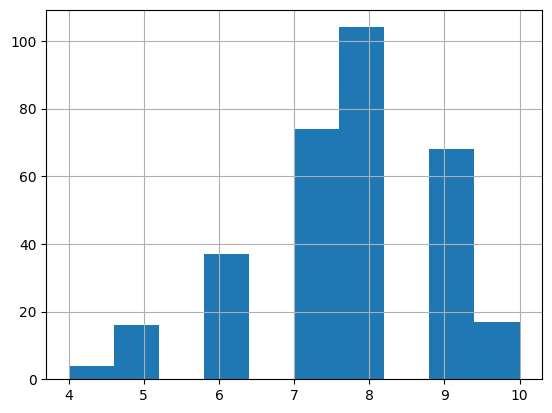

In [52]:
exact_diffs_ser = pd.Series(exact_diffs)
approx_diffs_ser = pd.Series(approx_diffs)
exact_diffs_ser.hist(bins=10)


<Axes: >

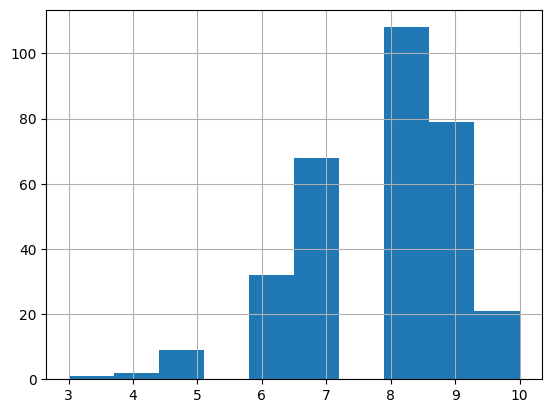

In [53]:
approx_diffs_ser.hist(bins=10)

# Ile pierwszych miejsc się zgadza

### Porównanie exact z approx

In [54]:
def compare(a: list[str], b: list[str]):
    assert (len (a) == len(b))
    for i, j in zip(a, b):
        if i == j:
            continue
        else:
            return False
    return True

<Axes: >

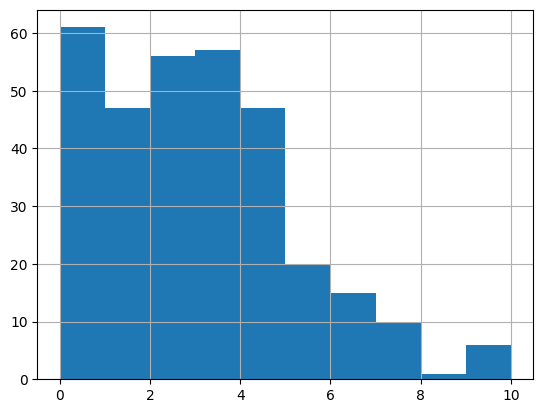

In [55]:
matching_count = [0 for i in range(0, 12)]
distances = []
for i, j in zip(exact_ranking, approx_ranking_4000):
    rank = 0
    for indx in range(1, len(i)):
        if compare(i[0: indx], j[0:indx]):
            rank += 1
    matching_count[rank] += 1
    distances.append(rank)

exact_diffs_ser = pd.Series(distances)
exact_diffs_ser.hist()





In [56]:
matching_count

[61, 47, 56, 57, 47, 20, 15, 10, 1, 1, 5, 0]

### Exact z shap

<Axes: >

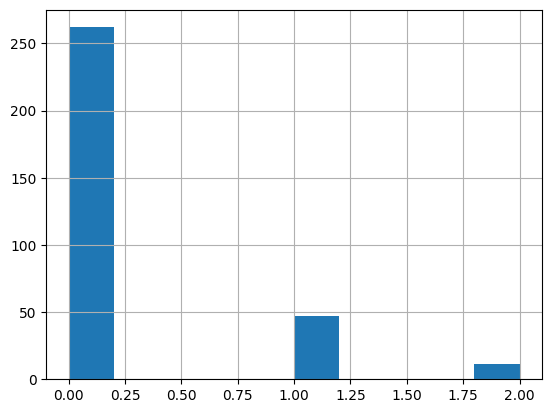

In [58]:

matching_count = [0 for i in range(0, 12)]
distances = []
for i, j in zip(exact_ranking, shap_ranking):
    rank = 0
    for indx in range(1, len(i)):
        if compare(i[0: indx], j[0:indx]):
            rank += 1
    matching_count[rank] += 1
    distances.append(rank)

exact_diffs_ser = pd.Series(distances)
exact_diffs_ser.hist(bins=10)





In [59]:
matching_count

[262, 47, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Approx z shap

<Axes: >

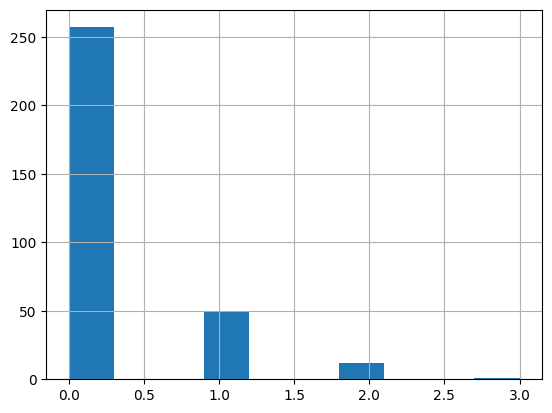

In [61]:
matching_count = [0 for i in range(0, 12)]
distances = []
for i, j in zip(approx_ranking_4000, shap_ranking):
    rank = 0
    for indx in range(1, len(i)):
        if compare(i[0: indx], j[0:indx]):
            rank += 1
    matching_count[rank] += 1
    distances.append(rank)

exact_diffs_ser = pd.Series(distances)
exact_diffs_ser.hist()





In [62]:
matching_count

[257, 50, 12, 1, 0, 0, 0, 0, 0, 0, 0, 0]

### Porównainie wszystkich trzech jednocześnie

In [63]:
def compare(a: list[str], b: list[str], c: list[str]):
    assert (len (a) == len(b))
    assert(len(a) == len(c))
    for i, j, y in zip(a, b, c):
        if i == j and i == y:
            continue
        else:
            return False
    return True

<Axes: >

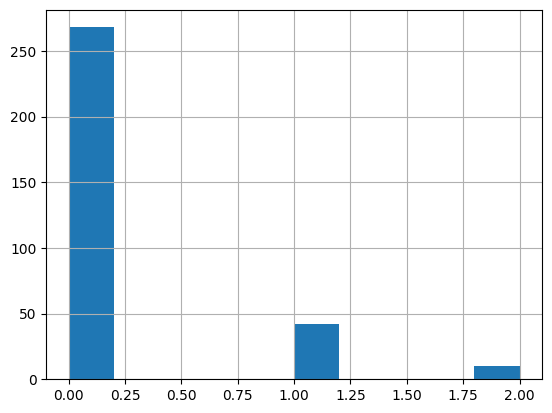

In [64]:
matching_count = [0 for i in range(0, 12)]
distances = []
for i, j, y in zip(approx_ranking_4000, shap_ranking, exact_ranking):
    rank = 0
    for indx in range(1, len(i)):
        if compare(i[0: indx], j[0:indx], y[0:indx]):
            rank += 1
    matching_count[rank] += 1
    distances.append(rank)

exact_diffs_ser = pd.Series(distances)
exact_diffs_ser.hist()





In [65]:
matching_count

[268, 42, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Porównanie dla PGI

In [72]:
pgi_wine_exact_ranking = np.load(pgi_wine_exact_path)
pgi_wine_shap_ranking = np.load(pgi_wine_shap_path)
pgi_wine_approx_ranking = np.load(pgi_wine_approx_path)



In [73]:
print(f"exact mean: {np.mean(pgi_wine_exact_ranking)}")
print(f"approx mean: {np.mean(pgi_wine_approx_ranking)}")
print(f"shap mean: {np.mean(pgi_wine_shap_ranking)}")

exact mean: 0.30338761009075615
approx mean: 0.3034437559209082
shap mean: 0.3097186281591527


<Axes: >

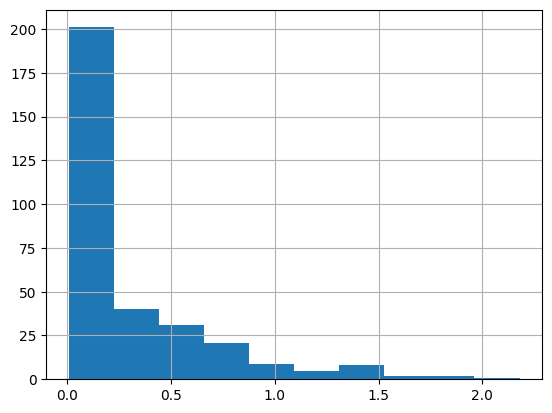

In [70]:
pgi_wine_exact_ranking = np.load(pgi_wine_exact_path)
exact_diffs_ser = pd.Series(pgi_wine_exact_ranking)
exact_diffs_ser.hist()

In [69]:
pgi_wine_exact_ranking.shape

(320,)